<a href="https://colab.research.google.com/github/chetai/chetai.github.io/blob/master/segment_scaled_churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data prep

- Assuming data is complete and accurate.
- Quick check in Excel
  - each customer only shows up maximum 12 rows (months). doesn't show up in subsequent year if it's renewed. 
  - number of unique customers = 3368. no discrepancies when deduped with column 'renew', meaning one customer = one renewal value
- Other notes
  - pricing: assume month to month. base $120/month includes 10,000 MTU's


In [ ]:
import pandas as pd
import numpy as np
import matplotlib as mlp
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# upload csv to github private repo to avoid re-uploading from local machine
url = 'https://raw.githubusercontent.com/chetai/misc/main/scaled_churn_rev.csv'
df = pd.read_csv(url)
# Dataset is now stored in a Pandas Dataframe

In [ ]:
# data preview/description
  #df.dtypes

In [ ]:
# data prep
# convert column names to lower case for more efficient coding
df.columns=df.columns.str.lower()
 
# convert objects to datetime
df['month'] = pd.to_datetime(df['month'])
df['first_paid_date'] = pd.to_datetime(df['first_paid_date'])
 
# get year from date columns to view to calculate annual churn later
df['first_paid_year'] = df['first_paid_date'].dt.year
 
# bining MTU based on Segment pricing tier: up to 10k = base, 10k-25k= low, 25k-100k = med, 100k+ = high
  # for ranking high risk customers to allocate customer success resources
df['mtu_bin'] = pd.cut(df['mtu'], [0, 10000, 25000, 100000, 9999999], labels=['base','low', 'med', 'high'])
 
# data preview
df.head(3)

,month,u_customer_id,customer_type,first_paid_date,months_since_start,workspace_id,all_sources_count,active_sources_count,source_types,counts_by_source_type,all_destinations_count,active_destinations_count,all_integrations_count,active_integrations_count,destination_names,counts_by_destination_name,destination_categories,destination_categories_counts,mtu,price,discount,revenue,throughput,api_calls,objects_synced,server_side_integration_calls,warehouse_rows_synced,anonymous_users,num_users,active_users,total_events,additive_events,removal_events,renewed,first_paid_year,mtu_bin
0,2017-05-01,hzhfpwgjfzuq,SS,2017-01-31,4,5ejootJ78a,2.0,2.0,"[\n ""Javascript"",\n ""Ruby""\n]","[\n 1,\n 1\n]",6.0,0.0,8.0,0.0,"[\n ""AdRoll"",\n ""FullStory"",\n ""Google Anal...","[\n 1,\n 1,\n 1,\n 2,\n 2,\n 1\n]","[\n ""Advertising"",\n ""Analytics"",\n ""CRMs"",...","[\n 1,\n 4,\n 2,\n 2,\n 5,\n 1,\n 2,\n ...",43.0,120,1.0,120.0,617.162791,26538.0,0.0,53642.0,0.0,30.0,4.0,1.0,7.0,NaN,NaN,0,2017,base
1,2017-05-01,hwapjyqzdvjc,SS,2017-04-30,1,NpuW5nqxIR,1.0,1.0,"[\n ""Stripe""\n]",[\n 1\n],1.0,0.0,1.0,0.0,"[\n ""Redshift""\n]",[\n 1\n],"[\n ""Warehouses""\n]",[\n 1\n],0.0,120,1.0,120.0,NaN,0.0,38867052.0,0.0,223926.0,0.0,1.0,1.0,36.0,NaN,NaN,1,2017,NaN
2,2017-05-01,hxxiqtvdjcrk,SS,2016-12-31,5,qyjgTMZatS,3.0,2.0,"[\n ""HTTP API"",\n ""Javascript""\n]","[\n 1,\n 2\n]",1.0,0.0,1.0,0.0,"[\n ""Mixpanel""\n]",[\n 1\n],"[\n ""Analytics"",\n ""Email"",\n ""Push Notific...","[\n 1,\n 1,\n 1,\n 1\n]",203.0,120,1.0,120.0,6324.679803,1283910.0,0.0,1298000.0,0.0,27.0,1.0,1.0,207.0,NaN,NaN,1,2016,base


In [ ]:
# dedupe customer_ids in the data set so we can count renewals by unique customer_ids: df_u_customer- 'u' = unique
  # keep the latest record of each customer by sorting 'months_since_start' descending first.
df_u_customer = df.sort_values('months_since_start',ascending=False).drop_duplicates('u_customer_id').sort_index()
print (df_u_customer.shape)

(3368, 36)


# Opportunity Sizing

Text(0.5, 1.0, 'total renewed')

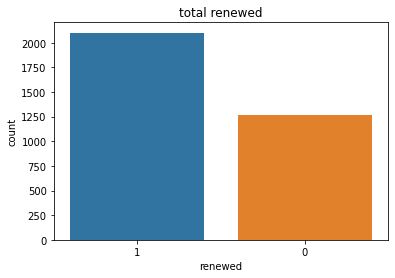

In [ ]:
# bar graph showing churn of all customers during all time periods covered by the dataset
sns.countplot(x = 'renewed', data=df_u_customer, order=[1,0])
sns.set(style='darkgrid')
plt.title('total renewed')

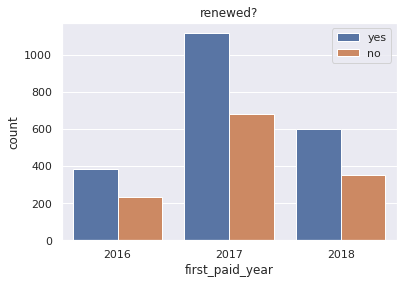

In [ ]:
# bar graph showing churn by first_paid_year
sns.countplot(x='first_paid_year', hue='renewed', data=df_u_customer, hue_order=[1,0])
sns.set(style='darkgrid')
plt.title('renewed?')
plt.legend(['yes','no'])

In [ ]:
# annual churn rate. see column renewed value '0'.
df_u_customer.groupby('first_paid_year')['renewed'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

first_paid_year  renewed
2016             1          62.5%
                 0          37.5%
2017             1          62.1%
                 0          37.9%
2018             1          63.0%
                 0          37.0%
Name: renewed, dtype: object

Observation:
churn rate is consistently around 37-38% for customers that started in 2016, 2017, 2018

---



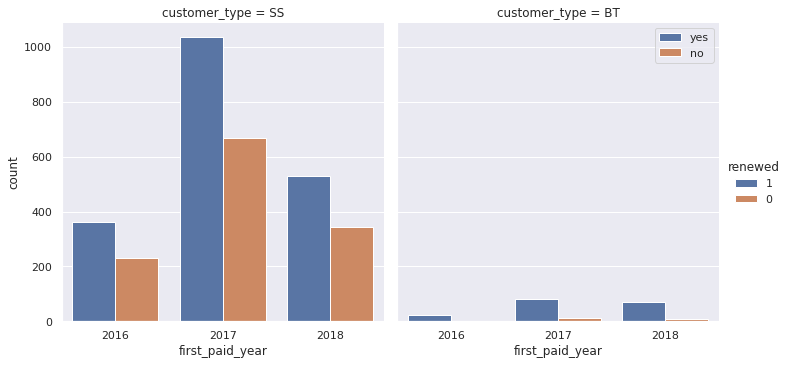

In [ ]:
# need to split out the annual churn rate above into BT and SS. 
sns.catplot(x='first_paid_year', hue='renewed', col='customer_type', data=df_u_customer, hue_order=[1,0], kind='count', height=5, aspect=1)
sns.set(style='darkgrid')
plt.legend(['yes','no'])

In [ ]:
# annual churn rate grouped by customer_type
df_u_customer.groupby(['first_paid_year','customer_type'])['renewed'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

# OPTIONAL todo: do monthly churn for SS (avg 5% a month) and check the average months it takes for customers to leave. check if number of integration decreases during this time

first_paid_year  customer_type  renewed
2016             BT             1          96.0%
                                0           4.0%
                 SS             1          61.0%
                                0          39.0%
2017             BT             1          86.2%
                                0          13.8%
                 SS             1          60.8%
                                0          39.2%
2018             BT             1          89.7%
                                0          10.3%
                 SS             1          60.6%
                                0          39.4%
Name: renewed, dtype: object

Observation:
- BT churn is consistently low: 4%, 14%, 10%. 
  - generally accpetable churn rate for entreprise SaaS is 5-7% annual for established companies. should aim to bring it down to the usual market churn rate for cdp's.
  - Segment is popular with earlier-stage companies ($1-3M in funding), especially in e-commrce, web, Saas and Ads. Given the volitility of these types of companies, it's worth check if the companies that didn't renew still exists, or are in operational freeze. 
- SS churn is consistently high: 39%, 39%, 39%. likely due to lack of knowledge of cdp and guidance from professional serivices

# Segmentation

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


AxesSubplot(0.125,0.125;0.775x0.755) AxesSubplot(0.125,0.125;0.775x0.755)


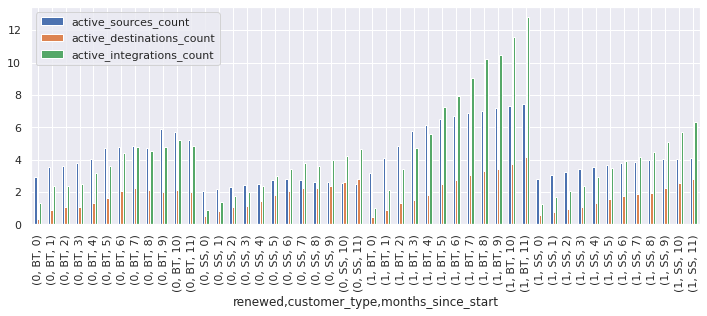

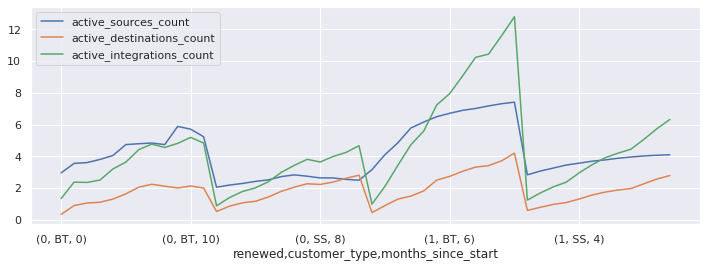

In [ ]:
# bar and line graph showing the growth trend of count of active sources, destinations, and integrations over the first 12 months
  #categorized by renewal, customer type
bar = df.groupby(['renewed','customer_type','months_since_start'])['active_sources_count',
                                                   'active_destinations_count',
                                                   'active_integrations_count'].mean().plot(kind='bar', stacked=False, figsize=(12,4))
line = df.groupby(['renewed','customer_type','months_since_start'])['active_sources_count',
                                                   'active_destinations_count',
                                                   'active_integrations_count'].mean().plot(kind='line', stacked=False, figsize=(12,4))                                                  
print(bar,line)
                                                

Observation
- avg number of active_sources
  - Stays high but flat because those are the first things a customer would set up. They are usually static because a company's data source (e.g. a ecommerce webpage + a mobile site) don't change much. 
  - We see that BT's that rewned has a big jump in sources around months 2-4 likely because enterprise customers may have multiple brands with multiple sources (e.g. websites) that get added after a pilot is in prod.
- avg number of active_destinations and integrations 
  - the main drivers of usage, because a customer can't really do analysis or ds unless data from the sources are collected by a destination such as BQ or Google analytics
  - for the churned customers, we can see from the charts above that their # of active destinations and integrations only grows a little in the first 6 months and lays relatively flat after. 
  - for the renewed customers, the growth rate of destinations, and especially integrations, has much steeper growth. this is a indication that they are seeing value in Segment and have been continuously expanding their usage

- Recommended action to lower churn rate:
  - set automatic triggers that sends an alert to Customer Success when a new SS or BT customer have less than 2 active destinations set up in the workspace by month 5. ask customer success to follow up and understand their challenges and provide guidance on how to gain value from Segment.
  - smaller customers (likely SS customers) are less likely to have robust and comprehensive data infrastructure and analytics capabilities, and are therefore often at a loss with how to proceed with using Segment. It would be helpful to remind them periodically to sign up for Segment University to learn more about data analytics, so they can better think about how to use their customer data. It would also be helpful for Segment to provide use case docs for different industries and companies of varying sizes to educate users.


In [ ]:
# high risk customers at month 5 with high-med mtu that started using Segment in 2018
df[(df.months_since_start == 5) & 
   (df.first_paid_year == 2018) &
   ((df.active_destinations_count <= 2) | (df.active_integrations_count <= 3)) &
   ((df.mtu_bin == 'high') | (df.mtu_bin == 'med'))
   ].u_customer_id.count()


39

^ example filter for high risk but high revenue potential customers to focus on

In [ ]:
# % of customers with 0 active destinations set up before they churned = 41.7%. strong indicator
df_u_customer.groupby(['renewed','customer_type'])['active_destinations_count'].value_counts(normalize=True).head(10).mul(100).round(1).astype(str) + '%'

renewed  customer_type  active_destinations_count
0        BT             0.0                          41.7%
                        2.0                          25.0%
                        1.0                           8.3%
                        3.0                           8.3%
                        6.0                           8.3%
                        8.0                           8.3%
         SS             0.0                          28.3%
                        1.0                          18.1%
                        2.0                          13.8%
                        3.0                           8.0%
Name: active_destinations_count, dtype: object

In [ ]:
# % of customers with 0 active integrations set up before they churned = 41.7%. strong indicator of churn
df_u_customer.groupby(['renewed','customer_type'])['active_integrations_count'].value_counts(normalize=True).head(10).mul(100).round(1).astype(str) + '%'

renewed  customer_type  active_integrations_count
0        BT             0.0                          41.7%
                        7.0                          16.7%
                        3.0                           8.3%
                        4.0                           8.3%
                        5.0                           8.3%
                        6.0                           8.3%
                        26.0                          8.3%
         SS             0.0                          28.3%
                        2.0                          13.8%
                        1.0                           9.4%
Name: active_integrations_count, dtype: object

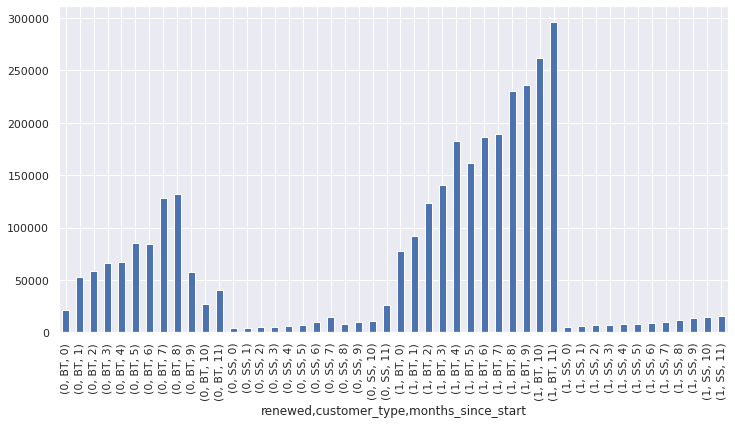

In [ ]:
#mtu
bar = df.groupby(['renewed','customer_type','months_since_start'])['mtu'].mean().plot(kind='bar', stacked=False, figsize=(12,6))

Observation
  - not a strong predictor of churn by itself, as the mtu of both churned and unchurned customers go up with time. MTUs can be tracked as long as a source is connected and no destination/integration is needed. An orphan source likely means that no actions are done on the data, signalling low platform engagement.
  - though we can observe that there's a sharp drop by month 8 for BT and month 7 for SS, indicating that these are the most common time for customers to stop using segment. Customer success should engage before this time- confirms the recommendation of engagement within 6 months as described above.
  - high monthly mtu suggests that the customer is paying high price. it's important that they are getting the value they are seeking. We should focus on customers with high MTUS but low or no destination and integration set up, which means they are not analysing the data to get value out of segment.

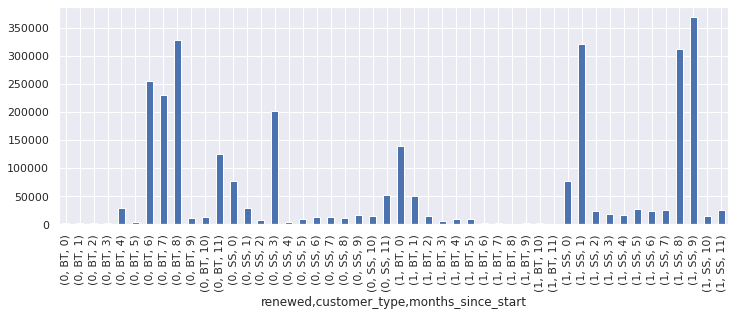

In [ ]:
#throughput
df.groupby(['renewed','customer_type','months_since_start'])['throughput'].mean().plot(kind='bar', stacked=False, figsize=(12,4))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  after removing the cwd from sys.path.


AxesSubplot(0.125,0.125;0.775x0.755) AxesSubplot(0.125,0.125;0.775x0.755)


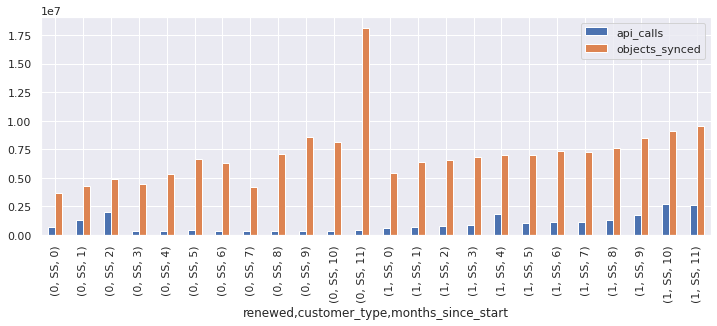

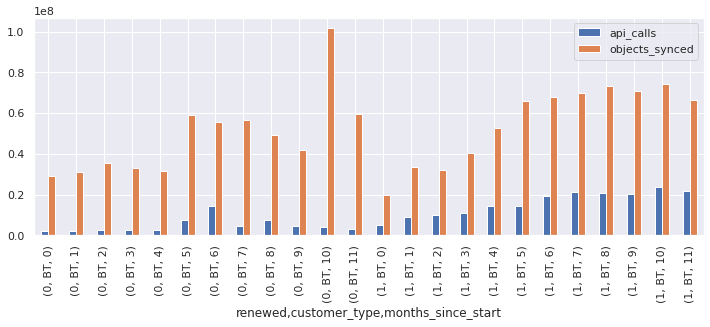

In [ ]:
# api_calls + objects synced, SS and BT
  # not a strong predictor of churn. see observations below
api_obj_ss = df.groupby(['renewed','customer_type','months_since_start'])['api_calls','objects_synced'].mean().filter(like='SS', axis=0).plot(kind='bar', stacked=False, figsize=(12,4))
api_obj_bt = df.groupby(['renewed','customer_type','months_since_start'])['api_calls','objects_synced'].mean().filter(like='BT', axis=0).plot(kind='bar', stacked=False, figsize=(12,4))

print (api_obj_ss, api_obj_bt)

Observation
  - not a strong predictor of churn. api calls and object syncs go up and down with the customer's datasource (e.g. website) traffic. 

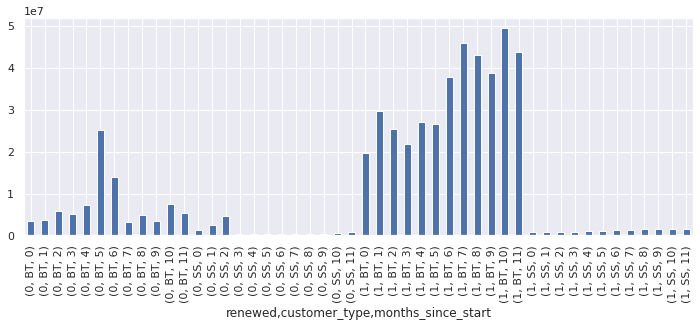

In [ ]:
# warehouse_rows_synced
df.groupby(['renewed','customer_type','months_since_start'])['warehouse_rows_synced'].mean().plot(kind='bar', stacked=False, figsize=(12,4))

Observation: warehouse_rows_synced is a decent predictor of renewal, and it's similar to active destination and integration. can omit from presentation deck.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


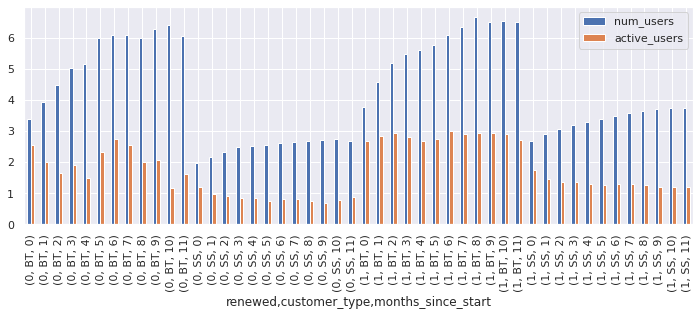

In [ ]:
# num_users, active_users
df.groupby(['renewed','customer_type','months_since_start'])['num_users','active_users'].mean().plot(kind='bar', stacked=False, figsize=(12,4))

Observation: little change over time. poor predictor. most companies would have a few folks from IT, marketing, and data teams on Segment, and user provision normally stays relatively static.

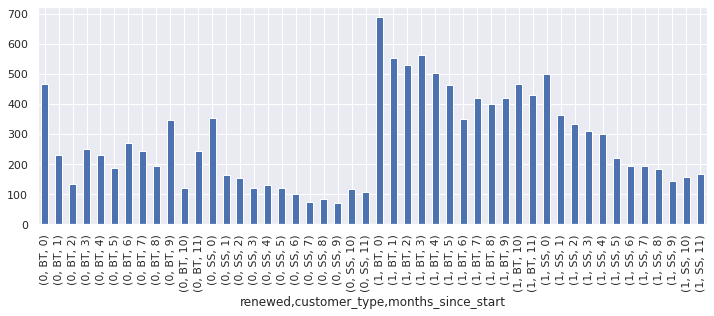

In [ ]:
# total_events
df.groupby(['renewed','customer_type','months_since_start'])['total_events'].mean().plot(kind='bar', stacked=False, figsize=(12,4))

Observation
  - Trigger notification for Customer Success to engage when total_events falls below 250 for BT, and 150 for SS, and are on the decline in the first 2-3 months. This means that the customer is not configuring Segment.

True


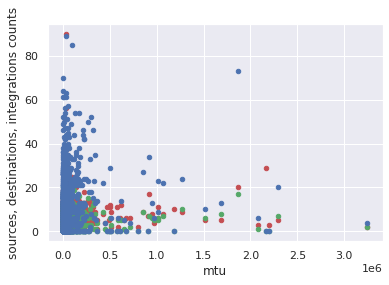

In [ ]:
# scatter plot to visualize the relationship between mtu and active sources, destinations, integrations.
sources = df_u_customer.plot.scatter(x='mtu', y='active_sources_count', color='r')
destinations = df_u_customer.plot.scatter(x='mtu', y='active_destinations_count', color='g', ax=sources )
integrations = df_u_customer.plot.scatter(x='mtu', y='active_integrations_count', color='b', ax=sources)

sources.set_ylabel('sources, destinations, integrations counts')

print(sources == destinations == integrations)

Observation
  - no clear relationship

AxesSubplot(0.125,0.125;0.775x0.755) AxesSubplot(0.125,0.125;0.775x0.755) AxesSubplot(0.125,0.125;0.775x0.755)


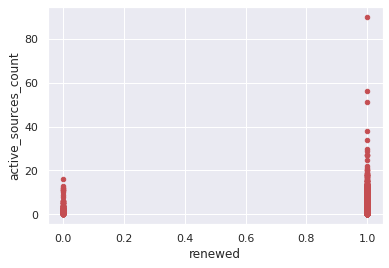

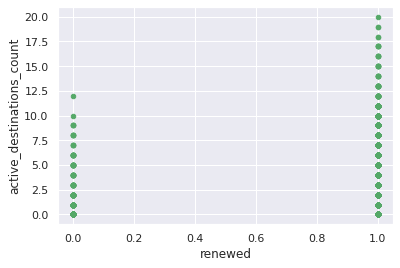

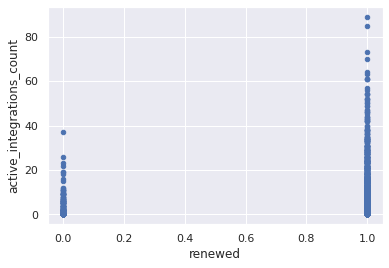

In [ ]:
# scatter plot to visualize the relationship between renewal and active sources, destinations, integrations.
sources = df_u_customer.plot.scatter(x='renewed', y='active_sources_count', color='r')
destinations = df_u_customer.plot.scatter(x='renewed', y='active_destinations_count', color='g')
integrations = df_u_customer.plot.scatter(x='renewed', y='active_integrations_count', color='b')

print(sources , destinations , integrations)

Observation
 - number of integration is the strongest predictor for renewal